In [ ]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.functional import F
from tqdm import trange
import numpy as np
from torch.nn import LogSoftmax

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls

drive  sample_data


In [ ]:
from sample_data.utils import get_oxford_splits,custom_plot_training_stats

In [ ]:
use_gpu = True

device = torch.device("cuda:0" if torch.cuda.is_available() and use_gpu else "cpu") # New


In [ ]:

class CNN_phase1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #layer 1
            torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),



            #layer 2
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            #layer 3
            torch.nn.MaxPool2d(kernel_size=2,stride=2),

            #layer 4
            torch.nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            #layer 5
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 6
            torch.nn.Conv2d(in_channels = 96, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            #layer 7
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 8
            torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),
            #layer 9
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 10 fc
            torch.nn.Flatten(),
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 80)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
class CNN_phase2(nn.Module):
    def __init__(self, pretrained_cnn, num_classes):
        super(CNN_phase2, self).__init__()

        # Create a new CNN model with the same convolutional layers as the pretrained model
        self.model = nn.Sequential(
            *list(pretrained_cnn.model.children())[:-6]  # Keep only convolutional layers, remove last 3 FC layers
        )

        # Define new fully connected layers
        self.fc1 = nn.Linear(256*4*4, 1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 80)

        # Initialize the weights of the new fully connected layers
        self.fc1.weight.data = pretrained_cnn.model[-3].weight.data.view(1024, -1)
        self.fc1.bias.data = pretrained_cnn.model[-3].bias.data
        self.fc2.weight.data = pretrained_cnn.model[-2].weight.data.view(128, -1)
        self.fc2.bias.data = pretrained_cnn.model[-2].bias.data
        self.fc3.weight.data = pretrained_cnn.model[-1].weight.data.view(80, -1)
        self.fc3.bias.data = pretrained_cnn.model[-1].bias.data

    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

In [ ]:

class CNN2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            #layer 1
            torch.nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),



            #layer 2
            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.ReLU(),

            #layer 3
            torch.nn.MaxPool2d(kernel_size=2,stride=2),

            #layer 4
            torch.nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=96),
            torch.nn.ReLU(),

            #layer 5
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 6
            torch.nn.Conv2d(in_channels = 96, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.ReLU(),
            #layer 7
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 8
            torch.nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, padding = 1),
            torch.nn.BatchNorm2d(num_features=256),
            torch.nn.ReLU(),
            #layer 9
            torch.nn.MaxPool2d(kernel_size=2,stride=2),
            #layer 10 fc
            torch.nn.Flatten(),
            torch.nn.Linear(256*4*4, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 80)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
def train_one_epoch(model: nn.Module, optim: torch.optim.Optimizer,
         dataloader: DataLoader, loss_fn):
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    model.train()

    for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs) # Forward Pass, [N, 10]
        loss = loss_fn(outputs, targets) # Compute Loss

        loss.backward() # Compute Gradients
        optim.step() # Update parameters
        optim.zero_grad() # zero the parameter's gradients

        _, preds = torch.max(outputs, dim=1) # Explain, [N]
        running_corrects += torch.sum(preds == targets)
        running_loss += loss.item()

        if batch_indx == 0:
            print(outputs.device)

    epoch_acc = (running_corrects / num_samples) * 100
    epoch_loss = (running_loss / num_batches)

    return epoch_acc, epoch_loss

In [ ]:
def test_model(model: nn.Module,
         dataloader: DataLoader, loss_fn):

    # utils
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    running_corrects = 0
    running_loss = 0.0

    model.eval() # you must call `model.eval()` to set dropout and batch normalization layers to evaluation mode before running inference.
    with torch.no_grad(): # explain
        # more on torch.no_grad(): https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html#disabling-gradient-tracking

        for batch_indx, (inputs, targets) in enumerate(dataloader): # Get a batch of Data
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs) # Forward Pass
            loss = loss_fn(outputs, targets) # Compute Loss

            # loss.backward() # Compute Gradients
            # optim.step() # Update parameters
            # optim.zero_grad() # zero the parameter's gradients

            _, preds = torch.max(outputs, 1) #
            running_corrects += torch.sum(preds == targets)
            running_loss += loss.item()


            if batch_indx == 0:
                print(outputs.device)

    test_acc = (running_corrects / num_samples) * 100
    test_loss = (running_loss / num_batches)

    return test_acc, test_loss

In [ ]:
# from utils import custom_plot_training_stats

def phase1():
    batch_size = 128
    num_epochs = 10
    learning_rate = 0.005

    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)

    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }


    model = CNN_phase1()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()

    acc_history = {'train': [], 'test': []}
    loss_history = {'train': [], 'test': []}

    for epoch in trange(num_epochs):
        train_acc, train_loss = train_one_epoch(model=model, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)
        test_acc, test_loss = test_model(model=model, dataloader=full_dataloaders['test'], loss_fn=cross_entropy)

        acc_history['train'].append(train_acc)
        acc_history['test'].append(test_acc)
        loss_history['train'].append(train_loss)
        loss_history['test'].append(test_loss)
    custom_plot_training_stats(acc_history, loss_history, ['train', 'test'], title='cnn1', dir='phase1_plots')


In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/10 [00:00<?, ?it/s]

cuda:0
cuda:0


 10%|█         | 1/10 [00:34<05:09, 34.40s/it]

cuda:0
cuda:0


 20%|██        | 2/10 [01:07<04:30, 33.85s/it]

cuda:0
cuda:0


 30%|███       | 3/10 [01:41<03:55, 33.64s/it]

cuda:0
cuda:0


 40%|████      | 4/10 [02:14<03:20, 33.49s/it]

cuda:0
cuda:0


 50%|█████     | 5/10 [02:48<02:49, 33.81s/it]

cuda:0
cuda:0


 60%|██████    | 6/10 [03:21<02:14, 33.54s/it]

cuda:0
cuda:0


 70%|███████   | 7/10 [03:55<01:40, 33.40s/it]

cuda:0
cuda:0


 80%|████████  | 8/10 [04:28<01:06, 33.36s/it]

cuda:0
cuda:0


 90%|█████████ | 9/10 [05:01<00:33, 33.32s/it]

cuda:0
cuda:0


100%|██████████| 10/10 [05:34<00:00, 33.46s/it]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

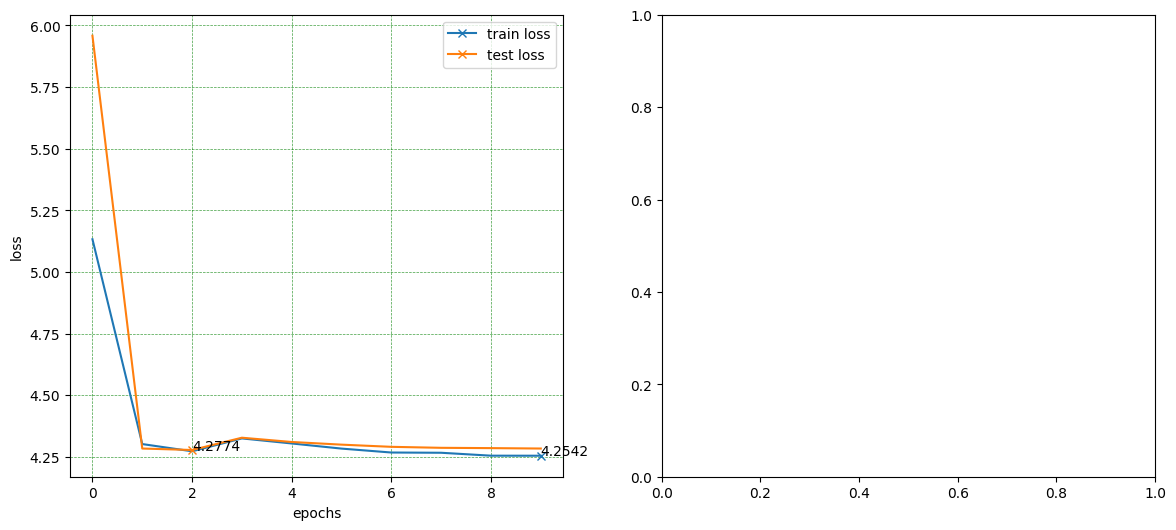

In [ ]:
phase1()

In [ ]:

# from utils import custom_plot_training_stats

def phase2():
    batch_size = 128
    num_epochs = 10
    learning_rate = 0.005

    A_train_dl, A_test_dl, B_train_dl, B_test_dl, test_all = get_oxford_splits(batch_size=128)

    trainset = A_train_dl.dataset  # Access the dataset from the DataLoader
    testset = A_test_dl.dataset    # Access the dataset from the DataLoader

    full_dataloaders = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True),
        'test': DataLoader(testset, batch_size=batch_size)
    }

    num_epochs = 0.6
    pretrained_model = CNN_phase1()
    pretrained_model = pretrained_model.to(device)

    new_model = CNN_phase1(pretrained_model)



    optimizer = torch.optim.Adam(new_model.parameters(), lr=learning_rate)
    cross_entropy = nn.CrossEntropyLoss()

    for epoch in trange(num_epochs):
        train_acc, train_loss = train_one_epoch(model=new_model, optim=optimizer, dataloader=full_dataloaders['train'], loss_fn=cross_entropy)